### Overview

This article will introduce a simple approach to begin to model energy markets. In our case we will be looking to see if we can ascertain any impact on German energy prices when the wind blows. Energy markets are quite complex to model nevertheless we will try to have a go at this using some of the tools available in the Python scientific computing ecosystem. I hope to demonstrate that it is possible with a little effort.

We will be using a mix of data from different sources combined with data from both LSEG Workspace and the Data Platform as well as our Point Connect service. We will be using some APIs and also some file-based sources. I will include any data files in the code repository and links in the Further Resources section so you can replicate. 

**Sections**

[Imports and Connections](#imports)

[API Calls](#api)

[Visualization Workflow](#viswork)

[Open Source Wind Data](#opwind)

[Locating Weather Monitoring Stations](#loc)

[Calculate nearest weather station for each windfarm](#cdist)

[Visualizations using GeoPandas, Shapefiles and Matplotlib](#vis)

[Getting Prices Data (our Labels)](#prices)

[Creating z-scores](#zsc)

[Implement Machine Learning Model](#imp)

[Split our dataset into train, evaluation and test sets](#spl)

[Create feature and label sets](#cre)

[Define our model to test and hand it our train, eval and test sets](#def)

[Generate Visual Outputs](#gen)

[Initial Observations](#obvs)

[Summary](#sum)

[Further Resources](#res)

**Pre-requisites:**

**LSEG Workspace** with access to [LSEG Data Library for Python](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python) (Free Trial Available)

**Python 3.x**

Required Python Packages: [lseg-data](https://pypi.org/project/lseg-data/), [pandas](https://pypi.org/project/pandas/), [numpy](https://pypi.org/project/numpy/), [matplotlib](https://pypi.org/project/matplotlib/), [geopandas](https://pypi.org/project/geopandas/), [shapely](https://pypi.org/project/Shapely/),[scipy](https://pypi.org/project/scipy/), [xgboost](https://pypi.org/project/xgboost/), [scikit-learn](https://pypi.org/project/scikit-learn/)

<a id='imports'></a>
#### Imports and connections

So lets start by importing some libraries and setting our credentials. 

In [1]:
import os
import lseg.data as ld
ld.open_session(app_key = '<APP_KEY'>)

### Session Open ###


<lseg.data.session.Definition object at 0x2153b6d9d00 {name='workspace'}>

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import cdist
import time
import scipy.stats as sci
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")

<a id='api'></a>
#### API Calls

The code below uses the new RDP Search service which is an excellent tool for finding content, in our case Physical Assets such as windfarms - but there are many other search views to help you out such as instruments, people, entities and many more ([reference guide](https://apidocs.refinitiv.com/Apps/ApiDocs#/details/L3NlYXJjaC9iZXRhMQ==/Lw==/POST/README)). In the code below we provide a filter which contains the query syntax we need to narrow down the Physical Asset universe to the ones we want - wind farms located in Germany.

In [3]:
dfRic = ld.discovery.search(
    view = ld.discovery.Views.PHYSICAL_ASSETS,
    filter = "RCSAssetTypeLeaf eq 'wind farm' and RCSRegionLeaf eq 'Germany'",
    top=5000
)
display(dfRic)

### get_service_and_details_omm


BusinessEntity                                    DocumentTitle  \
0     PHYSICALASSETxPLANT          Beetzendorf , Power; Wind Farm, Germany   
1     PHYSICALASSETxPLANT          Ruhlkirchen , Power; Wind Farm, Germany   
2     PHYSICALASSETxPLANT          Neuburxdorf , Power; Wind Farm, Germany   
3     PHYSICALASSETxPLANT  Uthlede - Lehnstedt , Power; Wind Farm, Germany   
4     PHYSICALASSETxPLANT          Groß Berßen , Power; Wind Farm, Germany   
...                   ...                                              ...   
3690  PHYSICALASSETxPLANT  Benndorf - Eisleben , Power; Wind Farm, Germany   
3691  PHYSICALASSETxPLANT          Hermersberg , Power; Wind Farm, Germany   
3692  PHYSICALASSETxPLANT         Zschornewitz , Power; Wind Farm, Germany   
3693  PHYSICALASSETxPLANT           Remlingen 1, Power; Wind Farm, Germany   
3694  PHYSICALASSETxPLANT   Hohnsl - Helmstedt , Power; Wind Farm, Germany   

           PermID           PI             RIC  
0     77309762291  77309762291  C}GW7309762291  
1     77309763214  77309763214  C}GW7309763214  
2     77309764013  77309764013  C}GW7309764013  
3     77309761589  77309761589  C}GW7309761589  
4     77309763049  77309763049  C}GW7309763049  
...           ...          ...             ...  
3690  77309761497  77309761497  C}GW7309761497  
3691  77309764754  77309764754  C}GW7309764754  
3692  77309762531  77309762531  C}GW7309762531  
3693  77309761470  77309761470  C}GW7309761470  
3694  77309762135  77309762135  C}GW7309762135  

[3695 rows x 5 columns]

Next we provide the list of physical asset RICs from the previous search to our get_data API call, along with a few fields we are interested in.

In [4]:
df = ld.get_data(
    universe = dfRic['RIC'].astype(str).values.tolist(),
    fields = ["TR.AssetName","TR.AssetLongitude","TR.AssetLatitude","TR.AssetCapacity", "TR.AssetCapacityDateFrom"])
df.dropna(inplace=True)
df

Instrument                  Name  Longitude   Latitude  Capacity  \
0     C}GW7309762291          Beetzendorf   11.053448  52.584512       3.0   
1     C}GW7309763214          Ruhlkirchen    9.194427  50.802734       9.6   
2     C}GW7309764013          Neuburxdorf   13.253754  51.472108       7.6   
3     C}GW7309761589  Uthlede - Lehnstedt    8.561855  53.289334      33.0   
4     C}GW7309763049          Groß Berßen    7.499621  52.788697       1.5   
...              ...                   ...        ...        ...       ...   
3690  C}GW7309761497  Benndorf - Eisleben   11.619176  51.574176       5.0   
3691  C}GW7309764754          Hermersberg    7.613222  49.323933       1.6   
3692  C}GW7309762531         Zschornewitz   12.412509  51.700265       8.0   
3693  C}GW7309761470           Remlingen 1  10.702136   52.11067      29.4   
3694  C}GW7309762135   Hohnsl - Helmstedt   10.994819   52.19798       3.0   

     Capacity Date From  
0            2001-01-01  
1            2013-11-01  
2            2003-01-01  
3            2015-01-01  
4            1995-01-01  
...                 ...  
3690         2001-01-01  
3691         2007-01-01  
3692         1999-01-01  
3693         2010-01-01  
3694         2003-01-01  

[3450 rows x 6 columns]

<a id='viswork'></a>
#### Visualization Workflow

We will be creating some visualisations using geopandas and shape files - to do this we need to create a geometry point type (a coordinate of longitude and latitude) so we can work with polygonal maps. Here we zip our longitude and latitude together to form this new Point datatype. We store this in a new geometry column.

In [5]:
geometry = [Point(xy) for xy in zip(df.Longitude,df.Latitude)]
df['geometry'] = geometry
df['closestWMO'] = np.nan
df

Instrument                  Name  Longitude   Latitude  Capacity  \
0     C}GW7309762291          Beetzendorf   11.053448  52.584512       3.0   
1     C}GW7309763214          Ruhlkirchen    9.194427  50.802734       9.6   
2     C}GW7309764013          Neuburxdorf   13.253754  51.472108       7.6   
3     C}GW7309761589  Uthlede - Lehnstedt    8.561855  53.289334      33.0   
4     C}GW7309763049          Groß Berßen    7.499621  52.788697       1.5   
...              ...                   ...        ...        ...       ...   
3690  C}GW7309761497  Benndorf - Eisleben   11.619176  51.574176       5.0   
3691  C}GW7309764754          Hermersberg    7.613222  49.323933       1.6   
3692  C}GW7309762531         Zschornewitz   12.412509  51.700265       8.0   
3693  C}GW7309761470           Remlingen 1  10.702136   52.11067      29.4   
3694  C}GW7309762135   Hohnsl - Helmstedt   10.994819   52.19798       3.0   

     Capacity Date From                     geometry  closestWMO  
0            2001-01-01  POINT (11.053448 52.584512)         NaN  
1            2013-11-01   POINT (9.194427 50.802734)         NaN  
2            2003-01-01  POINT (13.253754 51.472108)         NaN  
3            2015-01-01   POINT (8.561855 53.289334)         NaN  
4            1995-01-01   POINT (7.499621 52.788697)         NaN  
...                 ...                          ...         ...  
3690         2001-01-01  POINT (11.619176 51.574176)         NaN  
3691         2007-01-01   POINT (7.613222 49.323933)         NaN  
3692         1999-01-01  POINT (12.412509 51.700265)         NaN  
3693         2010-01-01   POINT (10.702136 52.11067)         NaN  
3694         2003-01-01   POINT (10.994819 52.19798)         NaN  

[3450 rows x 8 columns]

<a id='opwind'></a>
#### Open source wind data

Next we wish to download some wind data. There is plenty of open source data available - the data used here is sourced from Deutscher Wetterdienst (see further resources section for more detail) - this is from various weather monitoring stations in Germany - which record wind speed at a height of 10 meters. Maybe you have store of such or similar information in your own company. Here we are just reading it into a dataframe, wind. **Data
basis: Deutscher Wetterdienst, aggregated.**

In [6]:
wind = pd.read_csv('DEWindHourly.csv')
wind.head()

wmo  10020  10046  10055  10091  10113  10147  10162  10200  \
0  14/01/2016 00:00    5.1    3.1    4.1    4.1    5.1    4.1    4.1    4.1   
1  14/01/2016 01:00    4.1    3.1    3.1    5.1    4.1    5.1    4.1    5.1   
2  14/01/2016 02:00    5.1    3.1    3.1    4.1    4.1    5.1    4.1    3.1   
3  14/01/2016 03:00    5.1    3.1    3.1    5.1    4.1    5.1    3.1    5.1   
4  14/01/2016 04:00    1.0    3.1    5.1    3.1    4.1    4.1    4.1    4.1   

   10224  ...  10815  10852  10870  10895  10908  10929  10946  10948  10961  \
0    5.1  ...    2.1    4.1    5.1    6.2    NaN    3.1    2.1    2.1   13.9   
1    5.1  ...    2.1    4.1    3.1    6.2    NaN    2.1    3.1    2.1   12.9   
2    4.1  ...    3.1    4.1    4.1    7.2    NaN    2.1    3.1    3.1   12.9   
3    4.1  ...    3.1    4.1    4.1    5.1    NaN    1.0    3.1    2.1   14.9   
4    3.1  ...    3.1    2.1    4.1    4.1    NaN    1.0    3.1    1.0   10.8   

   10962  
0    7.2  
1    8.2  
2    8.2  
3    6.2  
4    4.1  

[5 rows x 52 columns]

We also want to get total wind output data for Germany - this I got from our Point Connect data service.

In [7]:
output = pd.read_csv('DEUwindprod.csv')
output.set_index('Date', inplace=True)
output.index = pd.to_datetime(output.index, format = '%d/%m/%Y %H:%M')
output.head()

Output MwH
Date                           
2016-01-01 12:00:00  1170.62800
2016-01-01 13:00:00   847.90200
2016-01-01 14:00:00   820.25950
2016-01-01 15:00:00  1093.58175
2016-01-01 16:00:00  1787.73625

Now we add two additional features Total Wind Speed (measuring across all weather stations) and Mean Wind Speed. **Data basis: Deutscher Wetterdienst, average and total added.**

In [8]:
wind.set_index('wmo', inplace=True)
wind.index = pd.to_datetime(wind.index)
wind.index.names=['Date']
wind['TotWin'] = wind.iloc[:,1:].sum(axis=1, skipna=True)
wind['MeanTot'] = wind.iloc[:,1:].mean(axis=1, skipna=True)
wind.head()

10020  10046  10055  10091  10113  10147  10162  10200  \
Date                                                                          
2016-01-14 00:00:00    5.1    3.1    4.1    4.1    5.1    4.1    4.1    4.1   
2016-01-14 01:00:00    4.1    3.1    3.1    5.1    4.1    5.1    4.1    5.1   
2016-01-14 02:00:00    5.1    3.1    3.1    4.1    4.1    5.1    4.1    3.1   
2016-01-14 03:00:00    5.1    3.1    3.1    5.1    4.1    5.1    3.1    5.1   
2016-01-14 04:00:00    1.0    3.1    5.1    3.1    4.1    4.1    4.1    4.1   

                     10224  10264  ...  10870  10895  10908  10929  10946  \
Date                               ...                                      
2016-01-14 00:00:00    5.1    3.1  ...    5.1    6.2    NaN    3.1    2.1   
2016-01-14 01:00:00    5.1    3.1  ...    3.1    6.2    NaN    2.1    3.1   
2016-01-14 02:00:00    4.1    3.1  ...    4.1    7.2    NaN    2.1    3.1   
2016-01-14 03:00:00    4.1    3.1  ...    4.1    5.1    NaN    1.0    3.1   
2016-01-14 04:00:00    3.1    3.1  ...    4.1    4.1    NaN    1.0    3.1   

                     10948  10961  10962  TotWin   MeanTot  
Date                                                        
2016-01-14 00:00:00    2.1   13.9    7.2   194.9  7.955102  
2016-01-14 01:00:00    2.1   12.9    8.2   189.0  7.560000  
2016-01-14 02:00:00    3.1   12.9    8.2   184.8  7.542857  
2016-01-14 03:00:00    2.1   14.9    6.2   171.5  7.000000  
2016-01-14 04:00:00    1.0   10.8    4.1   156.0  6.500000  

[5 rows x 53 columns]

We now join our wind output dataframe to our main wind features dataframe using an inner join on Date.

In [9]:
wind = wind.join(output, how='inner', on='Date')
wind.describe()

10020         10046         10055         10091         10113  \
count  30625.000000  30016.000000  31469.000000  30559.000000  30130.000000   
mean       7.179798      3.887883      6.443344      6.884208      5.956927   
std        3.140366      2.043747      3.247412      3.504434      2.828279   
min        0.500000      0.500000      0.500000      0.500000      0.500000   
25%        5.100000      2.100000      4.100000      4.100000      4.100000   
50%        7.200000      3.100000      6.200000      6.200000      5.100000   
75%        8.700000      5.100000      8.200000      8.700000      7.200000   
max       28.800000     15.900000     22.100000     23.100000     25.700000   

              10147         10162         10200         10224         10264  \
count  30408.000000  30281.000000  31351.000000  30655.000000  30232.000000   
mean       4.239549      3.903798      4.144633      4.322143      3.318173   
std        2.199805      1.990499      2.099516      2.307688      1.698319   
min        0.500000      0.500000      0.500000      0.500000      0.500000   
25%        2.600000      2.100000      2.100000      3.100000      2.100000   
50%        4.100000      3.100000      4.100000      4.100000      3.100000   
75%        5.100000      5.100000      5.100000      6.200000      4.100000   
max       19.000000     15.900000     18.000000     20.100000     12.900000   

       ...         10895         10908         10929         10946  \
count  ...  30799.000000  29963.000000  30314.000000  29201.000000   
mean   ...      3.153528      7.712863      2.417061      2.230297   
std    ...      1.965949      4.587546      1.556825      1.146934   
min    ...      0.500000      0.500000      0.500000      0.500000   
25%    ...      2.100000      4.100000      1.000000      1.000000   
50%    ...      2.600000      7.200000      2.100000      2.100000   
75%    ...      4.100000      9.800000      3.100000      3.100000   
max    ...     18.000000     30.900000     12.900000     11.800000   

              10948         10961         10962       TotWin       MeanTot  \
count  28651.000000  30534.000000  30686.000000  31912.00000  31912.000000   
mean       2.217553      6.837768      4.376598    181.39446      7.447921   
std        1.243888      3.889654      2.572592     73.87456      2.751302   
min        0.500000      0.500000      0.500000      0.00000      0.000000   
25%        1.000000      4.100000      3.100000    131.70000      5.485714   
50%        2.100000      6.200000      4.100000    167.30000      6.791578   
75%        3.100000      8.700000      5.100000    218.50000      8.796000   
max       11.800000     32.900000     24.200000    588.50000     23.078431   

         Output MwH  
count  31091.000000  
mean   11212.407872  
std     8616.785901  
min      137.500000  
25%     4558.045375  
50%     8916.729000  
75%    15448.654250  
max    44697.997000  

[8 rows x 54 columns]

<a id='loc'></a>
#### Locating Weather Monitoring Stations

For more detailed modelling I have included this section of code, where we can download the geographic locations of each of our wind monitoring sites. This will allow us to calculate the closest wind monitoring station to each of the windfarms and perhaps get a more accurate indication of local weather conditions on output. First we load the locations of our wind monitoring sites and then create a new geometry type for them. **Data
basis: Deutscher Wetterdienst, gridded data reproduced graphically**

In [10]:
location = pd.read_csv('deWMOlocation.csv')
location.head()

wmo      lat     long
0  10020  55.0111   8.4125
1  10046  54.3761  10.1433
2  10055  54.5297  11.0619
3  10091  54.6817  13.4367
4  10113  53.7139   7.1525

In [11]:
geometry2 = [Point(xy) for xy in zip(location.long,location.lat)]
location['geometry2'] = geometry2
location.head()

wmo      lat     long                geometry2
0  10020  55.0111   8.4125   POINT (8.4125 55.0111)
1  10046  54.3761  10.1433  POINT (10.1433 54.3761)
2  10055  54.5297  11.0619  POINT (11.0619 54.5297)
3  10091  54.6817  13.4367  POINT (13.4367 54.6817)
4  10113  53.7139   7.1525   POINT (7.1525 53.7139)

<a id='cdist'></a>
#### Calculate nearest weather station for each windfarm

Here we will calculate the closest weather monitoring station for each of our windfarms using the **scipy.spatial.distance cdist** routine which calculates the distance from one point to a range of coordinates - then we just select the minimum (closest) one and store it to our dataframe.

In [12]:
def closestWMO(point, plist):
    return plist[cdist([point], plist).argmin()]

In [13]:
pointList = location[['lat','long']].values
for i, row in df.iterrows():
    pointA = (df.Latitude[i],df.Longitude[i])
    sol = closestWMO(pointA, pointList)      
    df.closestWMO[i] = location['wmo'].loc[(location['lat']==sol[0]) & (location['long']==sol[1])].values[0]

df.head()   

Instrument                  Name  Longitude   Latitude  Capacity  \
0  C}GW7309762291          Beetzendorf   11.053448  52.584512       3.0   
1  C}GW7309763214          Ruhlkirchen    9.194427  50.802734       9.6   
2  C}GW7309764013          Neuburxdorf   13.253754  51.472108       7.6   
3  C}GW7309761589  Uthlede - Lehnstedt    8.561855  53.289334      33.0   
4  C}GW7309763049          Groß Berßen    7.499621  52.788697       1.5   

  Capacity Date From                     geometry  closestWMO  
0         2001-01-01  POINT (11.053448 52.584512)     10162.0  
1         2013-11-01   POINT (9.194427 50.802734)     10532.0  
2         2003-01-01  POINT (13.253754 51.472108)     10488.0  
3         2015-01-01   POINT (8.561855 53.289334)     10224.0  
4         1995-01-01   POINT (7.499621 52.788697)     10200.0

<a id='vis'></a>
#### Visualizations using GeoPandas, Shapefiles and Matplotlib

We will now do some visualisations working with GeoPandas and shapefiles. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Shapefiles are geospatial vector data formats that allow for storing of geographic type features such as lines, points and polygons (areas). There are many shapefiles available on the internet. I am using one I found for Germany and have included this is the the github repo containing this notebook so you can replicate. Here we just read in the file (I have also printed it so you can take a look at it) and then plot it using matplotlib.

In [14]:
gdf = gpd.read_file('/gadm36_DEU_shp/gadm36_DEU_4.shp')
print(gdf)

                                                geometry
0      MULTIPOLYGON (((9.74723 48.32449, 9.75169 48.3...
1      MULTIPOLYGON (((9.761 48.32106, 9.76107 48.321...
2      POLYGON ((9.82753 48.45703, 9.82244 48.45652, ...
3      POLYGON ((9.77582 48.3604, 9.77039 48.35825, 9...
4      POLYGON ((9.82753 48.45703, 9.82606 48.45836, ...
...                                                  ...
11297  POLYGON ((11.37983 51.07011, 11.37819 51.07428...
11298  POLYGON ((11.39456 51.0335, 11.39242 51.03406,...
11299  POLYGON ((11.30851 51.05867, 11.30701 51.05816...
11300  POLYGON ((11.19609 51.10009, 11.19666 51.10131...
11301  POLYGON ((11.37327 51.02007, 11.36869 51.0196,...

[11302 rows x 1 columns]


<Axes: >

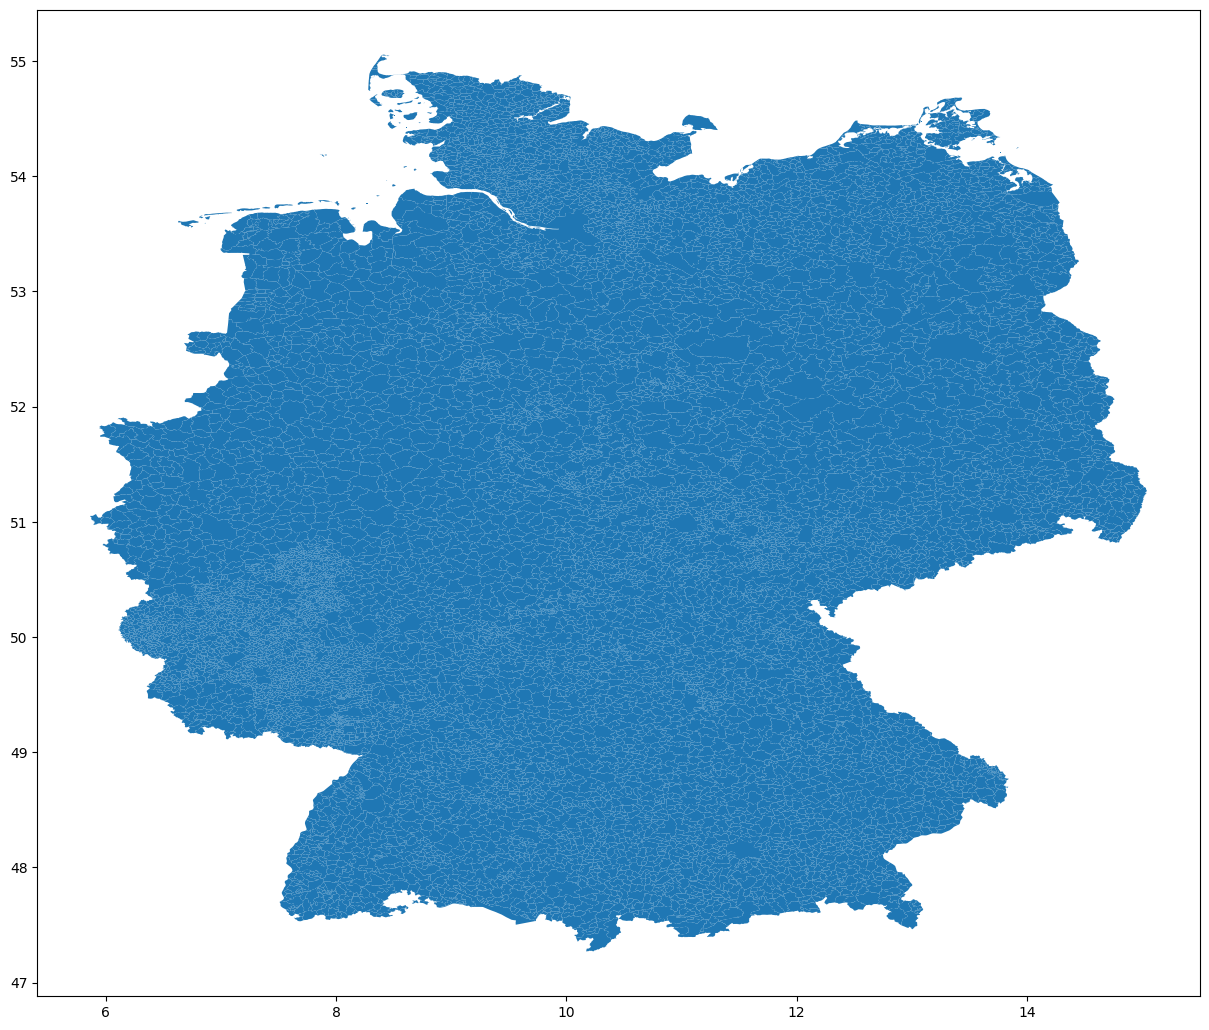

In [15]:
fig,ax = plt.subplots(figsize =(15,15))
gdf.plot(ax=ax)

Next we just convert our df dataframe containing all our windfarm geometry points and our location dataframe that contains the location of our weather monitoring stations to GeoDataFrames and plot both the map, and overlay our windfarms as green dots and our weather monitoring stations as blue dots. **Data
basis: Deutscher Wetterdienst, gridded data reproduced graphically.**

In [16]:
gdf2 = GeoDataFrame(df,geometry=geometry)
gdf2 = gdf2[(gdf2['Longitude'] >=5) & (gdf2['Longitude'] <20)]
gdf3 = GeoDataFrame(location,geometry=geometry2)

<Axes: >

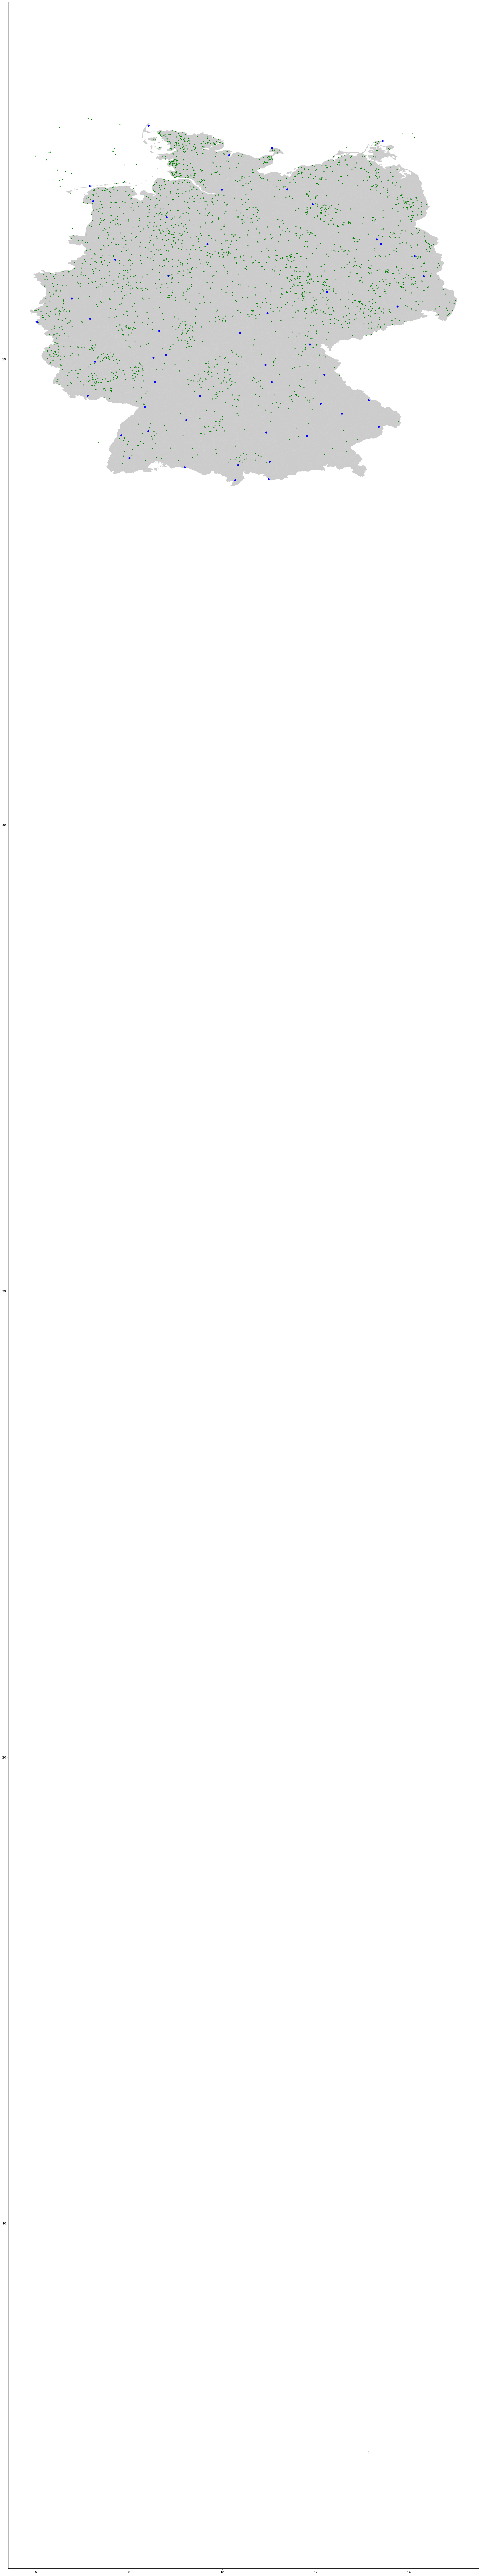

In [17]:
fig, ax = plt.subplots(figsize= (150,150))
gdf.plot(ax=ax,alpha = 0.4,color="grey")
gdf2.plot(ax=ax, color = "green", markersize = 5)
gdf3.plot(ax=ax, color = "blue", markersize = 30)

#### Get temperature data 

Here we are using hourly air temperature. This could be a demand side feature as colder temperatures might lead to more heating use or warmer temperatures might lead to more airconditioning etc. Note we are only taking the data from one station in middle of Germany, but for our exploratory purposes this will give us some indication of temperature conditions. **Data
basis: Deutscher Wetterdienst**. More information is available in the Further Resources section.

In [18]:
temp = pd.read_csv('DEairtemp.csv')
temp.set_index('Date', inplace=True)
temp.index = pd.to_datetime(temp.index)
temp.head()

AirTemp
Date                        
2016-01-14 00:00:00      2.9
2016-01-14 01:00:00      2.8
2016-01-14 02:00:00      2.6
2016-01-14 03:00:00      2.1
2016-01-14 04:00:00      1.6

In [19]:
wind = wind.join(temp, how='inner', on='Date')
wind.head()

10020  10046  10055  10091  10113  10147  10162  10200  \
Date                                                                          
2016-01-14 00:00:00    5.1    3.1    4.1    4.1    5.1    4.1    4.1    4.1   
2016-01-14 01:00:00    4.1    3.1    3.1    5.1    4.1    5.1    4.1    5.1   
2016-01-14 02:00:00    5.1    3.1    3.1    4.1    4.1    5.1    4.1    3.1   
2016-01-14 03:00:00    5.1    3.1    3.1    5.1    4.1    5.1    3.1    5.1   
2016-01-14 04:00:00    1.0    3.1    5.1    3.1    4.1    4.1    4.1    4.1   

                     10224  10264  ...  10908  10929  10946  10948  10961  \
Date                               ...                                      
2016-01-14 00:00:00    5.1    3.1  ...    NaN    3.1    2.1    2.1   13.9   
2016-01-14 01:00:00    5.1    3.1  ...    NaN    2.1    3.1    2.1   12.9   
2016-01-14 02:00:00    4.1    3.1  ...    NaN    2.1    3.1    3.1   12.9   
2016-01-14 03:00:00    4.1    3.1  ...    NaN    1.0    3.1    2.1   14.9   
2016-01-14 04:00:00    3.1    3.1  ...    NaN    1.0    3.1    1.0   10.8   

                     10962  TotWin   MeanTot  Output MwH  AirTemp  
Date                                                               
2016-01-14 00:00:00    7.2   194.9  7.955102     9561.25      2.9  
2016-01-14 01:00:00    8.2   189.0  7.560000     9201.25      2.8  
2016-01-14 02:00:00    8.2   184.8  7.542857     8975.25      2.6  
2016-01-14 03:00:00    6.2   171.5  7.000000     8285.75      2.1  
2016-01-14 04:00:00    4.1   156.0  6.500000     8373.25      1.6  

[5 rows x 55 columns]

#### Data on Solar energy

Here we are using hourly sum of solar incoming radiation data. At night the sun does not shine - so we should expect zero readings and from sunrise it should start to increase till sunset. Note, this is for only one area in the centre of Germany but for our exploratory purposes it will at least give us some indication on sunny conditions. **Data
basis: Deutscher Wetterdienst** More information is available in the Further Resources section. 

In [20]:
solar = pd.read_csv('DEsolar.csv')
solar.set_index('Date', inplace=True)
solar.index = pd.to_datetime(solar.index)
solar

FG_LBERG
Date                         
2016-01-14 00:00:00         0
2016-01-14 01:00:00         0
2016-01-14 02:00:00         0
2016-01-14 03:00:00         0
2016-01-14 04:00:00         0
...                       ...
2020-09-30 20:00:00         0
2020-09-30 21:00:00         0
2020-09-30 22:00:00         0
2020-09-30 23:00:00         0
2020-10-01 00:00:00         0

[41330 rows x 1 columns]

In [21]:
wind = wind.join(solar, how='inner', on='Date')
wind.head()

10020  10046  10055  10091  10113  10147  10162  10200  \
Date                                                                          
2016-01-14 00:00:00    5.1    3.1    4.1    4.1    5.1    4.1    4.1    4.1   
2016-01-14 01:00:00    4.1    3.1    3.1    5.1    4.1    5.1    4.1    5.1   
2016-01-14 02:00:00    5.1    3.1    3.1    4.1    4.1    5.1    4.1    3.1   
2016-01-14 03:00:00    5.1    3.1    3.1    5.1    4.1    5.1    3.1    5.1   
2016-01-14 04:00:00    1.0    3.1    5.1    3.1    4.1    4.1    4.1    4.1   

                     10224  10264  ...  10929  10946  10948  10961  10962  \
Date                               ...                                      
2016-01-14 00:00:00    5.1    3.1  ...    3.1    2.1    2.1   13.9    7.2   
2016-01-14 01:00:00    5.1    3.1  ...    2.1    3.1    2.1   12.9    8.2   
2016-01-14 02:00:00    4.1    3.1  ...    2.1    3.1    3.1   12.9    8.2   
2016-01-14 03:00:00    4.1    3.1  ...    1.0    3.1    2.1   14.9    6.2   
2016-01-14 04:00:00    3.1    3.1  ...    1.0    3.1    1.0   10.8    4.1   

                     TotWin   MeanTot  Output MwH  AirTemp  FG_LBERG  
Date                                                                  
2016-01-14 00:00:00   194.9  7.955102     9561.25      2.9         0  
2016-01-14 01:00:00   189.0  7.560000     9201.25      2.8         0  
2016-01-14 02:00:00   184.8  7.542857     8975.25      2.6         0  
2016-01-14 03:00:00   171.5  7.000000     8285.75      2.1         0  
2016-01-14 04:00:00   156.0  6.500000     8373.25      1.6         0  

[5 rows x 56 columns]

<a id='prices'></a>
#### Getting Prices Data (our Labels)
Thus far we have been building our feature matrix (our wind, temperature and solar features) and now we wish to build our label dataset - in our case we wish to look at hourly EPEX Spot energy prices. The price data on LSEG Platforms is in GMT - whereas all the other data is in local (CET) - therefore we need to shift our price data forward by 1hr to align it correctly. The source is our Point Connect repository - again have included this file in the github repo so you can replicate. 

In [22]:
pri = pd.read_csv('DEUprices1.csv')
pri.set_index('Date', inplace=True)
pri.index = pd.to_datetime(pri.index, format = '%d/%m/%Y %H:%M')
pri = pri.shift(+1, freq='H')
pri.head()

Val
Date                      
2015-01-01 01:00:00  18.29
2015-01-01 02:00:00  16.04
2015-01-01 03:00:00  14.60
2015-01-01 04:00:00  14.95
2015-01-01 05:00:00  14.50

Sometimes ML routines can work better with smoothed data so I have included a moving average, I dont use it here but include it for reference.


In [23]:
pri['val_mav'] = pri['Val'].rolling(window=5).mean()
pri.head()

Val  val_mav
Date                               
2015-01-01 01:00:00  18.29      NaN
2015-01-01 02:00:00  16.04      NaN
2015-01-01 03:00:00  14.60      NaN
2015-01-01 04:00:00  14.95      NaN
2015-01-01 05:00:00  14.50   15.676

<a id='zsc'></a>
#### Creating z-scores

We also wish to create some z-scores to normalise variation across the dataset.

In [24]:
b = list(pri.columns[0:2].values)
for col in b:
    col_zscore = col + '_zscore'
    pri[col_zscore] = (pri[col] - pri[col].mean())/pri[col].std(ddof=0)

pri

Val  val_mav  Val_zscore  val_mav_zscore
Date                                                           
2015-01-01 01:00:00  18.29      NaN   -1.038734             NaN
2015-01-01 02:00:00  16.04      NaN   -1.175974             NaN
2015-01-01 03:00:00  14.60      NaN   -1.263808             NaN
2015-01-01 04:00:00  14.95      NaN   -1.242459             NaN
2015-01-01 05:00:00  14.50   15.676   -1.269908       -1.270077
...                    ...      ...         ...             ...
2019-09-30 21:00:00  44.58   53.148    0.564845        1.152580
2019-09-30 22:00:00  34.60   50.032   -0.043892        0.951123
2019-09-30 23:00:00  33.09   43.776   -0.135996        0.546657
2019-10-01 00:00:00  31.58   38.624   -0.228100        0.213568
2019-10-01 01:00:00  30.04   34.778   -0.322033       -0.035086

[41617 rows x 4 columns]

We also need to normalize our feature matrix before handing it to our ML routine. 

In [25]:
wind_zs = wind
b = list(wind_zs.columns.values)
for col in b:
    col_zscore = col + '_zscore'
    wind_zs[col_zscore] = (wind_zs[col] - wind_zs[col].mean())/wind_zs[col].std(ddof=0) #this handles nan vals
    
wind_zs

10020  10046  10055  10091  10113  10147  10162  10200  \
Date                                                                          
2016-01-14 00:00:00    5.1    3.1    4.1    4.1    5.1    4.1    4.1    4.1   
2016-01-14 01:00:00    4.1    3.1    3.1    5.1    4.1    5.1    4.1    5.1   
2016-01-14 02:00:00    5.1    3.1    3.1    4.1    4.1    5.1    4.1    3.1   
2016-01-14 03:00:00    5.1    3.1    3.1    5.1    4.1    5.1    3.1    5.1   
2016-01-14 04:00:00    1.0    3.1    5.1    3.1    4.1    4.1    4.1    4.1   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2019-09-30 20:00:00    8.2    4.1   10.8   12.9    6.2    3.1    5.1    4.1   
2019-09-30 21:00:00    7.2    4.1   10.8   12.9    3.1    5.1    5.1    3.1   
2019-09-30 22:00:00    7.2    3.1    9.8   12.9    3.1    4.1    4.1    3.1   
2019-09-30 23:00:00    6.2    3.1    8.7   10.8    6.2    4.1    5.1    3.1   
2019-10-01 00:00:00    5.1    3.1    8.2   10.8    6.2    4.1    4.1    2.1   

                     10224  10264  ...  10929_zscore  10946_zscore  \
Date                               ...                               
2016-01-14 00:00:00    5.1    3.1  ...      0.438196     -0.113782   
2016-01-14 01:00:00    5.1    3.1  ...     -0.204143      0.758057   
2016-01-14 02:00:00    4.1    3.1  ...     -0.204143      0.758057   
2016-01-14 03:00:00    4.1    3.1  ...     -0.910716      0.758057   
2016-01-14 04:00:00    3.1    3.1  ...     -0.910716      0.758057   
...                    ...    ...  ...           ...           ...   
2019-09-30 20:00:00    4.1    3.1  ...     -0.204143     -1.072805   
2019-09-30 21:00:00    3.1    4.1  ...     -0.204143     -0.113782   
2019-09-30 22:00:00    4.1    3.1  ...     -0.910716     -1.072805   
2019-09-30 23:00:00    4.1    3.1  ...     -0.204143     -1.072805   
2019-10-01 00:00:00    3.1    3.1  ...     -0.910716     -0.113782   

                     10948_zscore  10961_zscore  10962_zscore  TotWin_zscore  \
Date                                                                           
2016-01-14 00:00:00     -0.094770      1.815468      1.097146       0.182519   
2016-01-14 01:00:00     -0.094770      1.558431      1.485810       0.102655   
2016-01-14 02:00:00      0.709100      1.558431      1.485810       0.045802   
2016-01-14 03:00:00     -0.094770      2.072505      0.708482      -0.134232   
2016-01-14 04:00:00     -0.979028      1.018653     -0.107712      -0.344047   
...                           ...           ...           ...            ...   
2019-09-30 20:00:00     -0.979028     -0.163718     -0.107712       0.274567   
2019-09-30 21:00:00     -0.979028      0.350356     -0.885039       0.167629   
2019-09-30 22:00:00     -0.979028      0.761615     -0.885039       0.022790   
2019-09-30 23:00:00     -0.979028      1.815468     -1.312570       0.129727   
2019-10-01 00:00:00     -0.979028      1.558431     -0.885039       0.006546   

                     MeanTot_zscore  Output MwH_zscore  AirTemp_zscore  \
Date                                                                     
2016-01-14 00:00:00        0.184021          -0.192091       -0.813935   
2016-01-14 01:00:00        0.040412          -0.233875       -0.825061   
2016-01-14 02:00:00        0.034181          -0.260107       -0.847312   
2016-01-14 03:00:00       -0.163133          -0.340135       -0.902942   
2016-01-14 04:00:00       -0.344870          -0.329979       -0.958571   
...                             ...                ...             ...   
2019-09-30 20:00:00        0.167556           0.676324        0.031632   
2019-09-30 21:00:00        0.110199           0.505910        0.087261   
2019-09-30 22:00:00       -0.097566           0.457026        0.142890   
2019-09-30 23:00:00        0.015040           0.368436        0.165142   
2019-10-01 00:00:00       -0.062815           0.299292        0.053883   

                     FG_LBERG_zscore  
Date                                  


We now join our prices (pri) dataframe to our main wind features (wind_zs) dataframe using an inner join on Date.

In [26]:
intersected_df = pri.join(wind_zs, how='inner', on='Date')
intersected_df

Val  val_mav  Val_zscore  val_mav_zscore  10020  10046  \
Date                                                                            
2016-01-14 00:00:00  24.29   26.056   -0.672759       -0.598984    5.1    3.1   
2016-01-14 01:00:00  23.06   24.744   -0.747784       -0.683808    4.1    3.1   
2016-01-14 02:00:00  22.22   23.794   -0.799020       -0.745228    5.1    3.1   
2016-01-14 03:00:00  22.03   23.024   -0.810609       -0.795011    5.1    3.1   
2016-01-14 04:00:00  22.53   22.826   -0.780111       -0.807812    1.0    3.1   
...                    ...      ...         ...             ...    ...    ...   
2019-09-30 20:00:00  49.27   52.510    0.850916        1.111332    8.2    4.1   
2019-09-30 21:00:00  44.58   53.148    0.564845        1.152580    7.2    4.1   
2019-09-30 22:00:00  34.60   50.032   -0.043892        0.951123    7.2    3.1   
2019-09-30 23:00:00  33.09   43.776   -0.135996        0.546657    6.2    3.1   
2019-10-01 00:00:00  31.58   38.624   -0.228100        0.213568    5.1    3.1   

                     10055  10091  10113  10147  ...  10929_zscore  \
Date                                             ...                 
2016-01-14 00:00:00    4.1    4.1    5.1    4.1  ...      0.438196   
2016-01-14 01:00:00    3.1    5.1    4.1    5.1  ...     -0.204143   
2016-01-14 02:00:00    3.1    4.1    4.1    5.1  ...     -0.204143   
2016-01-14 03:00:00    3.1    5.1    4.1    5.1  ...     -0.910716   
2016-01-14 04:00:00    5.1    3.1    4.1    4.1  ...     -0.910716   
...                    ...    ...    ...    ...  ...           ...   
2019-09-30 20:00:00   10.8   12.9    6.2    3.1  ...     -0.204143   
2019-09-30 21:00:00   10.8   12.9    3.1    5.1  ...     -0.204143   
2019-09-30 22:00:00    9.8   12.9    3.1    4.1  ...     -0.910716   
2019-09-30 23:00:00    8.7   10.8    6.2    4.1  ...     -0.204143   
2019-10-01 00:00:00    8.2   10.8    6.2    4.1  ...     -0.910716   

                     10946_zscore  10948_zscore  10961_zscore  10962_zscore  \
Date                                                                          
2016-01-14 00:00:00     -0.113782     -0.094770      1.815468      1.097146   
2016-01-14 01:00:00      0.758057     -0.094770      1.558431      1.485810   
2016-01-14 02:00:00      0.758057      0.709100      1.558431      1.485810   
2016-01-14 03:00:00      0.758057     -0.094770      2.072505      0.708482   
2016-01-14 04:00:00      0.758057     -0.979028      1.018653     -0.107712   
...                           ...           ...           ...           ...   
2019-09-30 20:00:00     -1.072805     -0.979028     -0.163718     -0.107712   
2019-09-30 21:00:00     -0.113782     -0.979028      0.350356     -0.885039   
2019-09-30 22:00:00     -1.072805     -0.979028      0.761615     -0.885039   
2019-09-30 23:00:00     -1.072805     -0.979028      1.815468     -1.312570   
2019-10-01 00:00:00     -0.113782     -0.979028      1.558431     -0.885039   

                     TotWin_zscore  MeanTot_zscore  Output MwH_zscore  \
Date                                                                    
2016-01-14 00:00:00       0.182519        0.184021          -0.192091   
2016-01-14 01:00:00       0.102655        0.040412          -0.233875   
2016-01-14 02:00:00       0.045802        0.034181          -0.260107   
2016-01-14 03:00:00      -0.134232       -0.163133          -0.340135   
2016-01-14 04:00:00      -0.344047       -0.344870          -0.329979   
...                            ...             ...                ...   
2019-09-30 20:00:00       0.274567        0.167556           0.676324   
2019-09-30 21:00:00       0.167629        0.110199           0.505910   
2019-09-30 22:00:00       0.022790       -0.097566           0.457026   
2019-09-30 23:00:00       0.129727        0.015040           0.368436   
2019-10-01 00:00:00       0.006546       -0.062815           0.299292   

                     AirTemp_zscore  FG_LBERG_zscore  
Date                     

#### Temporal Considerations

We want to compare the same hourly data for each day - so we need to create a daily series for each hour in the day as it is these series we want to model. The reason is that demand/supply profiles are different each hour of the day so - its not correct to compare hours in a continuous series ie hour 01 to hour 02 etc. The correct set up should be day 1 hour 1, day 2 hour 1, day 3 hour 1 etc. In this way we build up 24 discrete hourly profiles - as it is these we wish to model. Below we just extract the hour of our timestamp. 

In [27]:
intersected_df['hour'] = intersected_df.index.strftime('%H')

<a id='imp'></a>
#### Implement Machine Learning Model

For our modelling we will use an xgboost model - which a gradient-boosted decision tree class of algorithm - which is quite popular in the literature. We will apply the simplest vanilla implementation here to see if we can get any usable results. Obviously the ML area is quite technical and requires some mastery but you can use this codebase to extend and experiement as appropriate. 

<a id='spl'></a>
#### Split our dataset in to train, evaluation and test sets

We need to split our dataset into a training set, an evaluation set and a test set. We will hand the the ML routine only the training and evaluation datasets to generate its models. We will then test predictions made by that model against the test dataset to see if we can find anything useful. We split the data roughly at the halfway mark using 10% of our data as evaluation set. 

In [28]:
hour_ls = intersected_df.hour.unique()
hour_ls

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23'], dtype=object)

In [29]:
split_date = '2017-10-01'
eval_date = '2017-12-01'   
pri_train = {} 
pri_eval = {}
pri_test = {}

for h in hour_ls:
    pri_train[h] = pd.DataFrame((intersected_df.loc[(intersected_df.index <= split_date) 
                                                    & (intersected_df['hour']== h)].copy()),
                                                    columns = intersected_df.columns)
    pri_eval[h] = pd.DataFrame((intersected_df.loc[(intersected_df.index > split_date) 
                                                   & (intersected_df.index <= eval_date) 
                                                   & (intersected_df['hour']== h)].copy()),
                                                   columns = intersected_df.columns)
    pri_test[h] = pd.DataFrame((intersected_df.loc[(intersected_df.index > eval_date) 
                                                   & (intersected_df['hour']== h)].copy()),
                                                   columns = intersected_df.columns)

In [30]:
for h in hour_ls:
    print(h,pri_train[h].shape, pri_eval[h].shape, pri_test[h].shape)

00 (614, 117) (61, 117) (646, 117)
01 (622, 117) (61, 117) (661, 117)
02 (621, 117) (61, 117) (664, 117)
03 (613, 117) (61, 117) (651, 117)
04 (622, 117) (61, 117) (653, 117)
05 (621, 117) (61, 117) (655, 117)
06 (605, 117) (57, 117) (600, 117)
07 (624, 117) (58, 117) (659, 117)
08 (623, 117) (59, 117) (660, 117)
09 (610, 117) (59, 117) (616, 117)
10 (624, 117) (60, 117) (662, 117)
11 (624, 117) (61, 117) (658, 117)
12 (601, 117) (61, 117) (639, 117)
13 (624, 117) (61, 117) (661, 117)
14 (624, 117) (61, 117) (664, 117)
15 (608, 117) (61, 117) (641, 117)
16 (620, 117) (61, 117) (656, 117)
17 (619, 117) (61, 117) (657, 117)
18 (596, 117) (61, 117) (638, 117)
19 (618, 117) (61, 117) (658, 117)
20 (622, 117) (61, 117) (664, 117)
21 (612, 117) (59, 117) (645, 117)
22 (623, 117) (61, 117) (664, 117)
23 (623, 117) (61, 117) (660, 117)


<a id='cre'></a>
#### Create feature and label sets

We now need to seperate our training (pri_train), evaluation (pri_eval) and test (pri_test) dataframes into their feature and label set components. Here we create a small function to do this for us. The training, evaluation and test datasets contain both the raw and the normalised (_zscore) data. We only wish to pass the normalised feature data to the ML routine so we simply select the relevant zscore features. The function also takes in which target label parameter, which we use to select the column we want to model for.

In [31]:
def create_features(df, label=None):
    collist = df.columns.tolist()
    relcols = collist[60:len(collist)-1] 
    X = df[relcols]
    if label:
        y = df[label].to_frame()
        return X, y
    return X

<a id='def'></a>
#### Define our XGBoost model - hand it our train, eval and test sets

So we are now ready to hand each of our 3 datasets for each hour from 0 to 23 to the XGBoost routine to generate a model for each hour. We define our XGB model using the Regressor class and a squared error objective function. We then pass the training feature and label sets to the fit function along with our evalution set. Once the modeel is generated, we will then store the feature importance graph and then generate a prediction for each hour and then calculate the Mean Squared Error (MSE) for each prediction versus the observed label. 

In [32]:
ax_ls ={}
res ={}
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, early_stopping_rounds=50)

for h in hour_ls:
    #create our features, train, eval & test
    X_train, y_train = create_features(pri_train[h], label='Val_zscore')
    X_eval, y_eval = create_features(pri_eval[h], label='Val_zscore')
    X_test, y_test = create_features(pri_test[h], label='Val_zscore')
    #define our xgboost model
    reg.fit(X_train, y_train,
        eval_set=[(X_eval, y_eval)], 
        #early_stopping_rounds=50,
       verbose=False)
    #create and store feature importance plots
    ax_ls[h]= reg.get_booster().get_fscore()
    #create prediction from our xgboost model
    pri_test[h]['ML_Prediction'] = reg.predict(X_test)
    #calculate prediction accuracy using MSE
    res[h] = mean_squared_error(pri_test[h]['Val_zscore'].values, pri_test[h]['ML_Prediction'].values)

<a id='gen'></a>
#### Generate Visual Output
We have just created 24 hourly xgboost models, we now want to plot our feature importance (the higher the F-score the more important the feature) for each hourly series, as well as the accuracy of our ML generated predictions - using in our case the mean squared error (MSE) calculation we created above. We can easily do this is 2 steps.

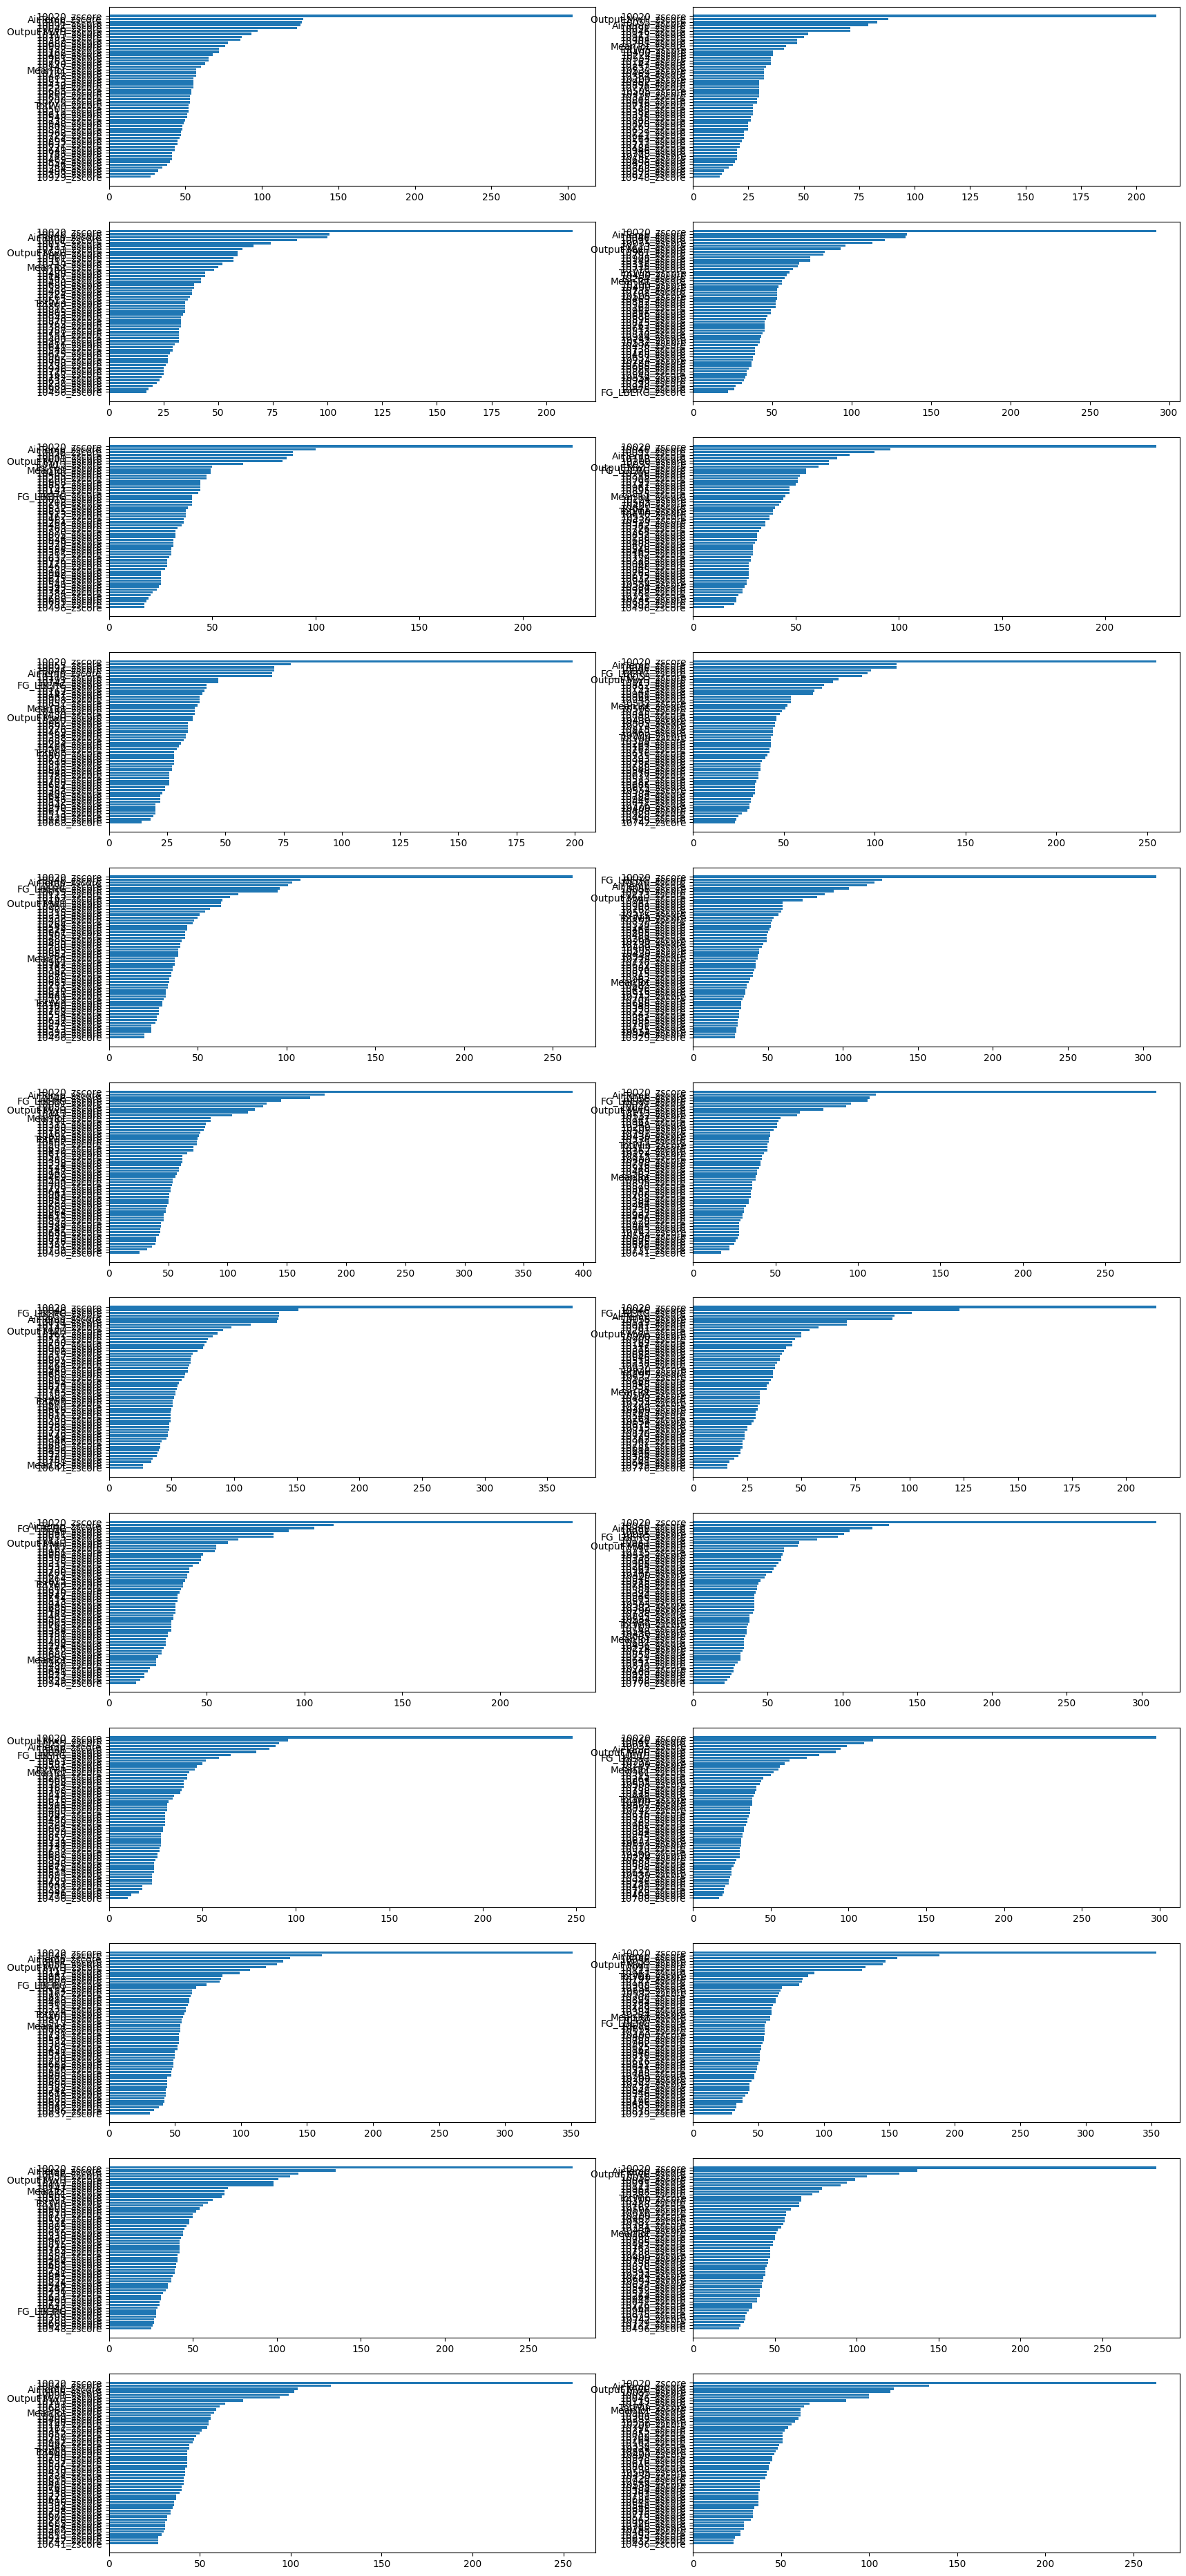

In [33]:
fig = plt.figure(figsize=(20,60))
for i,col in enumerate(hour_ls):
    bx=plt.subplot(15,2,i+1)
    data1 = OrderedDict(sorted(ax_ls[col].items(), key=lambda t: t[1]))
    plt.barh(range(len(data1)),data1.values(), align='center')
    plt.yticks(range(len(data1)),list(data1.keys()))
    plt.title = ("Hour " + col)

plt.show()

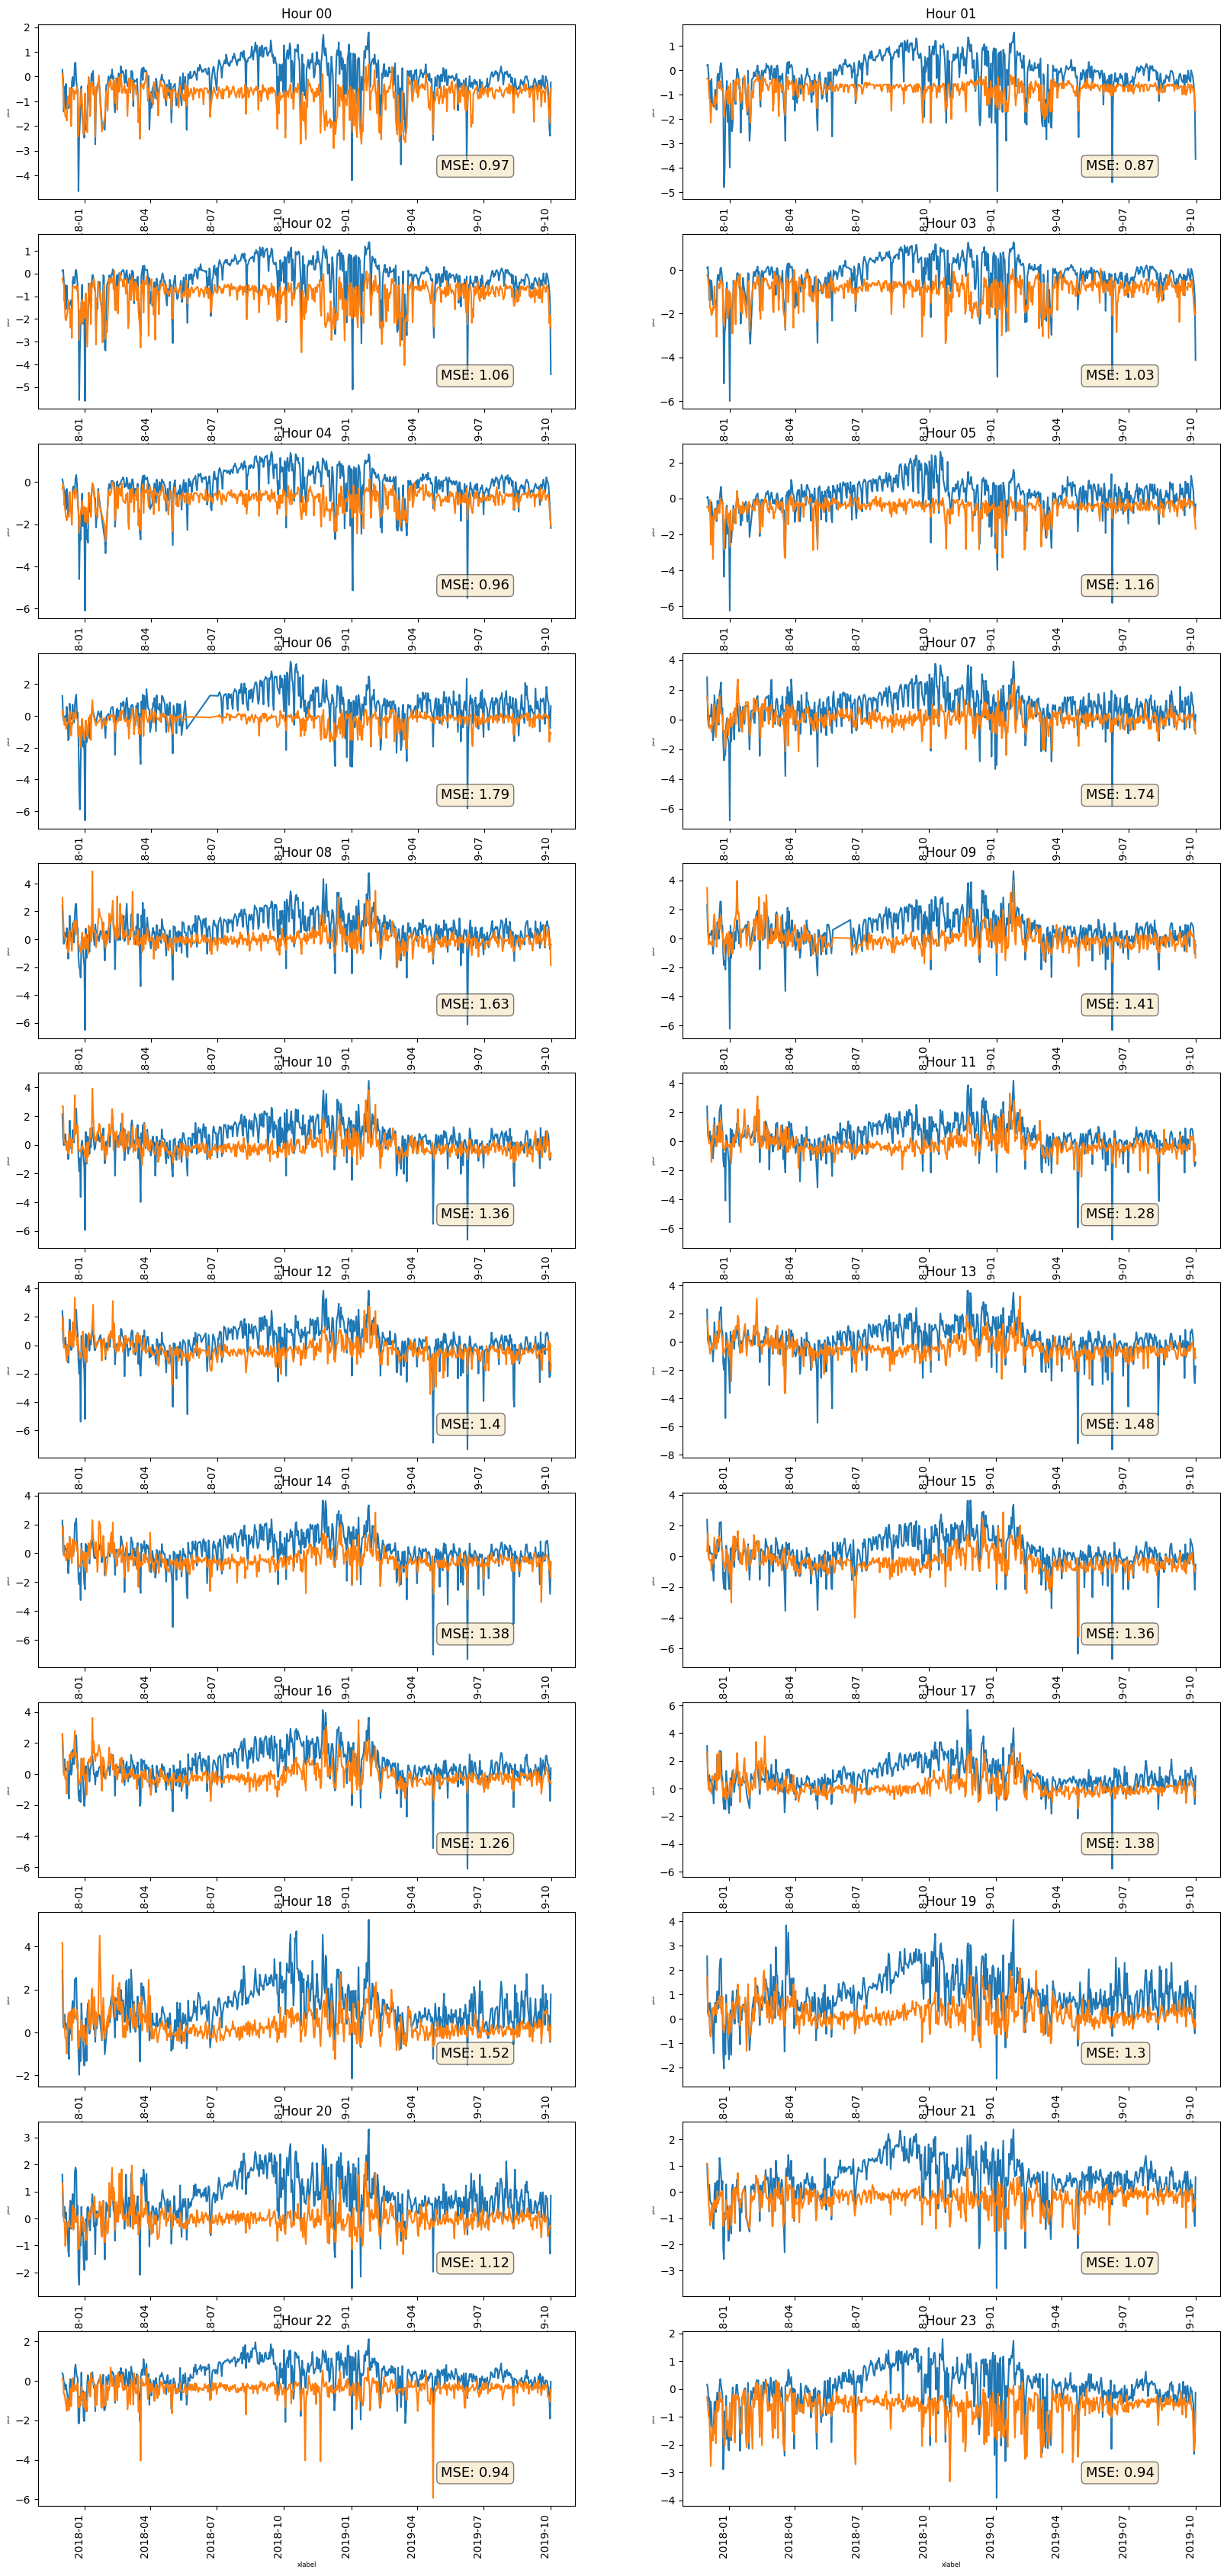

In [34]:
fig = plt.figure(figsize=(20,60))
for i,col in enumerate(hour_ls):
    ax=plt.subplot(15,2,i+1) 
    pri_test[col][['Val_zscore','ML_Prediction']].plot(ax=ax,legend=False,title = ("Hour " + col) )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_xlabel('xlabel', fontsize=6)
    ax.set_ylabel('ylabel', fontsize=3)
    ax.text(0.75, .15, "MSE: " + str(round(res[col],2)), transform=ax.transAxes, fontsize=13,
        verticalalignment='bottom',bbox=props)
    plt.xticks(rotation=90)
plt.show()

<a id='obvs'></a>
#### Initial Observations

From the line charts above, we can see that the generated models are able to predict some of the downward spikes in spot energy prices. The MSE varies from 0.73 (hour 01) to 1.56 (hour 6). There does seem to be quite some variation in accuracy even with this very simple and limited model. However, none of these are particularly accurate, MSE of 0 being perfect and MSE of 1 indicating 1 standard deviation. 

We can see for example that on some days prices went much lower than our prediction - this could be due for example to a day which was both windy and sunny (remember these energy sources are not stored but dumped to the grid - leading to the negative prices - the negative prices discourage use of thermal sources). We did have one feature included for solar energy - but it was for only one location in the centre of the country, as opposed to wind which we had much greater coverage for. Conversely, there are other days where the prediction was much lower than the observed, so perhaps it wasn't that sunny at all locations or thermal capacity had been dialled back etc. So we could expand our model to include new more complete features such more solar locations, thermal features and such. 

Our model does not really tell us anything about upward spikes as we have only included one demand side type of feature - air temperature - and only for one station in the centre of Germany - in our feature matrix. Again we could expand our model with features that might help us with this demand side modelling for example. 

Another next step might be to use only a subset of the highest F-score features and re-run the models to see if that can improve things, or indeed look at a suite of different classes of algorithm - we have only used xgboost but there are many other that we could implement within the main iterative routine I have given above. 

Further, we have been looking only at observed values. Remember, one of the features we are using is actual Wind Output - we wouldn't know this ahead of time. So clearly we need to know about forecast data. We know that energy markets are based around forecast data. So another next step would be to incorporate all of that data but that is beyond the scope of this introductory article.
<a id='sum'></a>
#### Summary

A lot of ground was covered in this article so let's summarize. We retrieved a set of physical asset (windfarms in our case) RICs from our excellent new RDP Search API. We used these to request some reference-type data for these windfarms using our LSEG Data Library for Python. We then created a new geometry 'Point' datatype where we stored locational co-ordinates for our windfarms. We followed this by loading some open source wind data, wind output data from our Point Connect repository and joined these together, creating 2 additional features along the way. We also loaded some open source solar energy and air temperature data. We then retrived the locations of our weather monitoring stations and as before, created a new geometry datatype for those. We were then able to calculate the closest weather monitoring station for each of our windfarms using the scipy.spatial cdist routine - though we didn't use it in ths introductory model other than for visualisation - I included it as it might prove useful were you to develop more complex models. We then downloaded a shape file for Germany, converted our pandas dataframes to GeoPandas dataframes and ploted overlays for both windfarms and wind monitoring stations. Next we read in some price data (EPEX Spot) to use for our label data, shifted it forward one hour to align with our local time (CET) features and we then started to normalise our datasets using z-scores. After joining our feature and label dataframes, we then added a feature called hour which tells us which hour the timestamp refers to. We then split our data into training, evaluation and test sets and defined our feature and label sets for each of the 24 hours in the day. Next we defined 24 different XGBoost ML models (one for each hour of the day), handing it the appropriate training and evaluation sets and ploted our feature importance F-scores. Finally, we used our model to generate a label prediction based on our hold-out or test feature matrix and plotted that against the observed label values. 

Whilst a simple and far from complete example, I hope this article can provide you with an idea of how to approach this area and a practical codebase to experiment and explore further. 

#### Further Resources

<a id='res'></a>
**Further Resources for LSEG Data Library for Python**

* [Overview](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python) 
* [Quick Start ](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python/quick-start)
* [Documentation](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python/documentation)
* [Tutorials](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python/tutorials)
* [Q&A Forums](https://community.developers.refinitiv.com/)

For Content Navigation in Workspace - please use the Data Item Browser Application: Type 'DIB' into Workspace Search Bar.

**Further Resources for LSEG Data Plaform APIs**

* [Overview](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis) 
* [Quick Start ](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/quick-start)
* [Documentation](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/documentation)
* [Downloads](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/download)
* [Tutorials](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/tutorials)
* [Q&A Forums](https://community.developers.refinitiv.com/)

For Content Navigation in RDP - please go [here](https://apidocs.refinitiv.com)

For more information on the Point Connect service please go [here](https://www.lseg.com/en/data-analytics/trading-solutions/commodities-trading/point-connect)

**Further Resources for Open Source German Weather Data kindly made public by** [DWD](https://www.dwd.de/EN/climate_environment/cdc/cdc_node.html) 
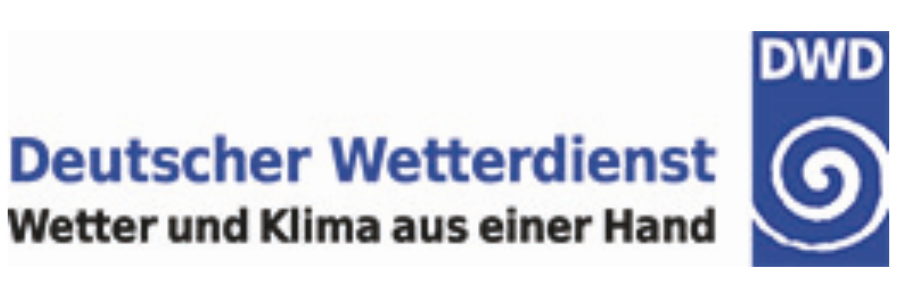

[Hourly Wind Data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/wind/historical/)

[Hourly Air Temperature - I used Station 01266, and field TT_TU](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/)

[Hourly Solar Readings - I used Station 00183, and field FG_LBERG](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/solar/)

Source of geospatial base data:  

Surveying authorities of the Länder and Federal Agency for Cartography and Geodesy 
(https://www.bkg.bund.de).

Source of satellite data: 
EUMETSAT (https://www.eumetsat.int) 
NOAA (https://www.noaa.gov)

**Further Resources for Shapefiles**

[German SHP Map kindly made public by GADM project](https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_DEU_shp.zip)